In [92]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cartopy.crs as ccrs
from pyresample import geometry, grid
import pyresample
import datetime
import metpy
import datetime
import s3fs
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from pyresample import geometry, grid
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from skimage.filters import laplace
from skimage.filters import unsharp_mask
from skimage.transform import resize
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

fs = s3fs.S3FileSystem(anon = True)
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
random.seed(42)

In [93]:
pc = ccrs.PlateCarree()
pc_params = pc.proj4_params
pc_extents = [-124.25, 32.25, -114.25, 42.25]
shape = [500, 500]
target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, pc_extents)

latlon1 = [40.47, -121.465]
latlon2 = [40.675000000000004, -121.155]
coords1 = target_area.get_array_coordinates_from_lonlat(latlon1[1], latlon1[0])
coords1 = (round(coords1[0]), round(coords1[1]))
coords2 = target_area.get_array_coordinates_from_lonlat(latlon2[1], latlon2[0])
coords2 = (round(coords2[0]), round(coords2[1]))
lons = [coords1[0], coords2[0]]
lats = [coords2[1], coords1[1]]

In [95]:
landsat_path = '../landsat_files/landsat_files/'
landsat_img039 = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridAcent0.02deg.npy')
landsat_img103 = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridAcent0.02deg.npy')
landsat_img = landsat_img039 - landsat_img103

In [96]:
goes_path = '../landsat_files/'
goes_img039 = np.load(goes_path + 'OR_ABI-L1b-RadC-M6C07_G17_s20212401846176_e20212401848561_c20212401849003.npy')
goes_img103 = np.load(goes_path + 'OR_ABI-L1b-RadC-M6C14_G17_s20212401846176_e20212401848549_c20212401848593.npy')
goes_img = goes_img039 - goes_img103

Text(0.5, 1.0, 'goes')

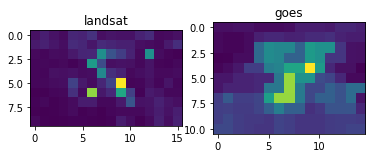

In [102]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(landsat_img)
ax[0].set_title('landsat')
ax[1].imshow(goes_img[lats[0]:lats[1], lons[0]:lons[1]])
ax[1].set_title('goes')

In [87]:
# landsat_img[landsat_img < 1] = 0
# goes_img[goes_img < 1] = 0

Text(0.5, 1.0, 'goes')

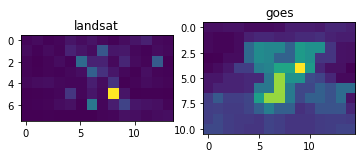

In [89]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(landsat_img[:, :-1])
ax[0].set_title('landsat')
ax[1].imshow(goes_img[lats[0]:lats[1], lons[0]:lons[1]])
ax[1].set_title('goes')

In [8]:
print(landsat_img.shape)
print(goes_img[lats[0]:lats[1], lons[0]:lons[1]].shape)

(8, 15)
(11, 15)


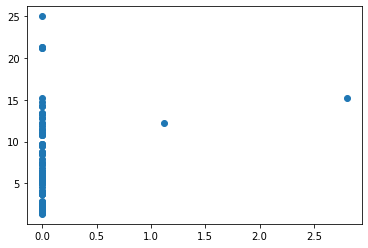

In [73]:
plt.scatter(landsat_img, np.flipud(goes_img[lats[0]+2:lats[1]-1, lons[0]:lons[1]]))

In [75]:
landsat_img = landsat_img[:, :-1]
goes_img = np.flipud(goes_img[lats[0]+2:lats[1]-1, lons[0]:lons[1]-1])

In [54]:
def load_image(array):
    """
    Returns loaded .npy file.
    
    Parameter path: Path to load .npy file from
    Precondition: path is a string
    """
    result = np.zeros((array.shape[0], array.shape[1], 3))
    result[:,:,0]= array
    result[:,:,1]= array
    result[:,:,2]= array
    return result

def preprocess_image(array):
    """
    Returns preprocessed input array.
    
    Parameter array: array to preprocess
    Precondition: array is a numpy array
    """
    hr_image = array
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 2) * 2
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def downscale_image(image):
    """
    Returns low resolution image after scaling down input image using nearest neighbor downsampling.

    Parameter image: 3D of 4D tensor of preprocessed image
    Precondition: image is a tensor
    """
    height, width = image.shape
    result = np.zeros((image.shape[0]//2, image.shape[1]//2, 3))
    smallimg = resize(image, (round(height/2), round(width/2)))
    result[:,:,0] = smallimg
    result[:,:,1] = smallimg
    result[:,:,2] = smallimg
    lr_image = tf.expand_dims(result, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

def esrgan_sharpening_img(image):
    """
    Returns dictionary containing errors after using the ESRGAN model.
    
    Parameter path: path of image not including file name
    Precondition: path is a string
    
    Parameter file: file of the image
    Precondition: file is a string of a .npy file
    """
    hr_image = preprocess_image(load_image(image))
    lr_image = downscale_image(image)
    fake_image = model(lr_image)
    fake_image = tf.squeeze(fake_image)

    hr_image = tf.squeeze(hr_image).numpy()
    lr_image = tf.squeeze(lr_image).numpy()
#     lr_image = resize(lr_image, (hr_image.shape[0], hr_image.shape[1], 3)).ravel()
#     fake_image = resize(fake_image.numpy(), (hr_image.shape[0], hr_image.shape[1], 3))

    return np.mean(fake_image, axis=2)

In [76]:
new_goes = esrgan_sharpening_img(goes_img)

In [77]:
new_goes.shape

(16, 28)

Text(0.5, 1.0, 'new goes')

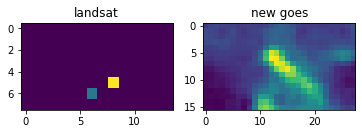

In [82]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(landsat_img)
ax[0].set_title('landsat')
ax[1].imshow(new_goes)
ax[1].set_title('new goes')

In [57]:
landsat_path = '../landsat_files/landsat_files/'
landsat_img039hr = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridA0.01deg.npy')
landsat_img103hr = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridA0.01deg.npy')
landsat_imghr = landsat_img039hr - landsat_img103hr

Text(0.5, 1.0, 'new goes')

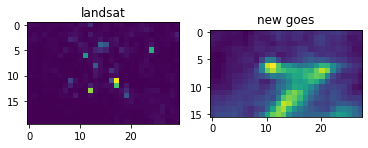

In [58]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(landsat_imghr)
ax[0].set_title('landsat')
ax[1].imshow(new_goes)
ax[1].set_title('new goes')

In [60]:
landsat_imghr.shape

(20, 30)

In [64]:
landsat_path = '../landsat_files/landsat_files/'
landsat_img039 = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridA0.02deg.npy')
landsat_img103 = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridA0.02deg.npy')
landsat_img02 = landsat_img039 - landsat_img103
print(landsat_img02.shape)
landsat_img039 = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridA0.01deg.npy')
landsat_img103 = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridA0.01deg.npy')
landsat_img01 = landsat_img039 - landsat_img103
print(landsat_img01.shape)
landsat_img039 = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridA0.005deg.npy')
landsat_img103 = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridA0.005deg.npy')
landsat_img005 = landsat_img039 - landsat_img103
print(landsat_img005.shape)

(8, 15)
(20, 30)
(41, 62)
